In [25]:
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path, enet_path
from sklearn import datasets
from copy import deepcopy

In [2]:
# X, y = datasets.load_diabetes(return_X_y=True)
# X /= X.std(axis=0)
# X.shape

X = np.random.randn(100,10)
y = np.dot(X,[1,2,3,4,5,6,7,8,9,10])

# LASSO by Coordinate Descent Method

The code is the simplified version of ``_cd_fast.enet_coordinate_descent()`` with ``beta=0`` and ``l1_ratio=1`` from scikit-learn (source code:[lasso coodinate descent source](https://github.com/scikit-learn/scikit-learn/blob/483cd3eaa3c636a57ebb0dc4765531183b274df0/sklearn/linear_model/_cd_fast.pyx)). The original code is implemented in ``Cython``, and code here is pure python for convenience, easier to understand but __much slower__.

## Coordinate Descent Method Framework

1. randomly set $\beta^{(0)}$ for iteration 0
2. For $k$th iteration:\
   ----For $j=1$ to $p$:\
   --------$\beta^{(k)}_j = argmin_{\beta_j} \mathcal{L}_{l1}(\beta)=argmin_{\beta_j} \mathcal{L}_{l1}(\beta_1^{(k-1)}, \beta_2^{(k-1)},\ldots, \beta_{j-1}^{(k-1)}, \beta_j, \beta_{j+1}^{(k)}, \ldots, \beta_p^{(k-1)})$\
   ----Endfor\
   ----Check convergence: if yes, end algorithm; else continue update\
   Endfor
   

Here the objective function is 
$$\mathcal{L}_{l1}=\frac{1}{2N}(Y-X\beta)^T (Y-X\beta) + \lambda \left\lVert \beta \right\rVert_1$$
where the size of $X$, $Y$, $\beta$ is $N\times p$, $N\times 1$, $p\times 1$, which means $N$ samples and $p$ features.

## Coordinate Descent Method Update Details

To update the $\beta_j$, we need to find the $\beta_j^*\;\text{ s.t.}\; \frac{\partial \mathcal{L}_{l1}(\beta)}{\partial \beta_j}=0$.

Given $\mathcal{L}_{l1}(\beta) = \frac{1}{2N} \sum_{n=1}^N(y^{(n)} - \sum_{i=1}^p{x^{(n)}_i \beta_i})^2 + \lambda \left\lVert \beta \right\rVert_1$, we have
\begin{align}
\frac{\partial \mathcal{L}_{l1}(\beta)}{\partial \beta_j} 
&= -\frac{1}{N} \sum_{n=1}^N(y^{(n)} - \sum_{i=1}^p{x^{(n)}_i \beta_i}) \cdot x_j^{(n)} + \lambda \cdot \text{sgn}(\beta_j) \\
&= -\frac{1}{N} \sum_{n=1}^N (y^{(n)} - x^{(n)}_j \beta_j - \sum_{i\neq j}{x^{(n)}_i \beta_i}) \cdot x_j^{(n)} + \lambda \cdot \text{sgn}(\beta_j) \\
&= -\frac{1}{N} [\sum_{n=1}^N {x_j^{(n)} \cdot (y^{(n)} - \sum_{i\neq j}{x^{(n)}_i \beta_i})}] + \frac{\beta_j}{N} [\sum_{n=1}^N{(x^{(n)}_j)^2}] + \lambda \cdot \text{sgn}(\beta_j) \\
&= 0
\end{align}

Let residual $R = [r^{(1)}, r^{(2)}, \ldots, r^{(N)}]^T$, and $r^{(n)} = y^{(n)} - \sum_{i\neq j}{x^{(n)}_i \beta_i}$.

Let norm of the columns of $X$ be $norm\_cols\_X = [\sum_n(x_1^{(n)})^2,\; \sum_n(x_2^{(n)})^2,\;\ldots,\; \sum_n(x_p^{(n)})^2]^T$.

Then we have 
$$\frac{\partial \mathcal{L}_{l1}(\beta)}{\partial \beta_j} = -\frac{1}{N} \sum_{n=1}^N{r^{(n)} x_j^{(n)}} + \frac{\beta_j}{N} \cdot norm\_cols\_X_j + \lambda \cdot \text{sgn}(\beta_j) = 0.$$

Now let $tmp = \sum_{n=1}^N{r^{(n)} x_j^{(n)}} = R^T X_{:,j}$.

It's easy to get 
$$\beta_j^* = \frac{tmp - N\cdot \lambda \cdot \text{sgn}(\beta_j)}{norm\_cols\_X_j}$$

Here are different cases:
\begin{enumerate}
\item If $\beta_j>0$, then
$$\beta_j^* = \frac{tmp - \lambda N}{norm\_cols\_X_j} > 0,$$  
and we can have $tmp - \lambda N >0$, that is, when $tmp > \lambda N >0$.
\item If $\beta_j<0$, then
$$\beta_j^* = \frac{tmp + \lambda N}{norm\_cols\_X_j} < 0$$
and we can have $tmp + \lambda N <0$, that is, when $tmp < -\lambda N <0$.
\item Else $\beta_j^*=0$, that is, when $-\lambda N \le tmp \le \lambda N$.
\end{enumerate}

From cases 1 and 2, we can find $\text{sgn}(tmp)=\text{sgn}(\beta_j)$ always, so the solution can be rewritten as 
$$\text{if}\;\; |tmp| > \lambda N,\;\;\text{then}\;\;  \beta_j^* = \frac{\text{sgn}(tmp) \cdot (|tmp| - \lambda N)}{norm\_cols\_X_j}; \;\; \text{Else if}\;\; |tmp| <= \lambda N, \;\; \beta_j^* = 0.$$ 

The final solution can also be rewritten as
$$\beta_j^* = \frac{\text{sgn}(tmp) \cdot \max[|tmp| - \lambda N, \;0]}{norm\_cols\_X_j}$$

There is a plot for $\;tmp$ vs $\beta_j$:
<div>
<img src="./LASSOupdate.jpg" width="20%"/>
</div>

Computing regularization path using the lasso...


(-1.184363644720181,
 3.4596699798578108,
 -0.49997222048796663,
 10.4994166302473)

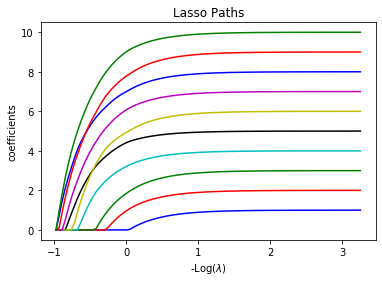

In [3]:
eps = 6e-5  # the smaller it is the longer is the path

print("Computing regularization path using the lasso...")
lambdas_lasso, coefs_lasso, _ = lasso_path(X, y, eps, fit_intercept=False)

# Display results

plt.figure(1)
colors = cycle(['b', 'r', 'g', 'c', 'k', 'y','m'])
neg_log_lambdas_lasso = -np.log10(lambdas_lasso)
for coef_l, c in zip(coefs_lasso, colors):
    l1 = plt.plot(neg_log_lambdas_lasso, coef_l, c=c)

plt.xlabel('-Log($\lambda$)')
plt.ylabel('coefficients')
plt.title('Lasso Paths')
plt.axis('tight')


## Simplified Code

To avoid compute the residual from scratch in each iteration ``n_iter`` and ``f_iter``, precompute the entire residual from the begin using initial weight ``w``, and update only term related with ``w_ii`` in each loop for ``ii=f_iter``.

In [4]:
def fsign(f):
    if f == 0.0:
        return 0
    elif f > 0:
        return 1
    else:
        return -1

def LASSO_coordinate_descent(X,y,lmbd,max_iter=1000,tol=1e-4):
    n_samples, n_features = X.shape
    
    # compute norms of the columns of X
    norm_cols_X = np.square(X).sum(axis=0)
    
    # initial value of the residuals and weights
    R = np.empty(n_samples, dtype=float)
    XtA = np.empty(n_features, dtype=float)
    w = np.empty(n_features, dtype=float)
    
    gap = tol + 1
    d_w_tol = tol
    
    
    R = y - np.dot(X, w)
    tol *= np.dot(y,y)
    for n_iter in range(max_iter):
        w_max = 0.0
        d_w_max = 0.0
        for f_iter in range(n_features):
            ii = f_iter
            if norm_cols_X[ii] <= 1e-3:
                continue
                
            w_ii = w[ii] #store previous value
            if w_ii != 0.0:
                R += w_ii * X[:,ii]
            tmp = (X[:,ii]*R).sum()
            
            # in original cython code, there is no need for lmbd to multiply with n_samples
            # but it seems only code below can output the same results
            w[ii] = fsign(tmp) * max(abs(tmp)-n_samples*lmbd, 0.0) / norm_cols_X[ii] 
            
            if w[ii] != 0.0:
                R -= w[ii] * X[:,ii] # Update residual
                
            # update the maximum absolute coefficient update
            d_w_ii = abs(w[ii] - w_ii)
            d_w_max = max(d_w_max, d_w_ii)
            
            w_max = max(w_max, abs(w[ii]))
        
        if w_max == 0.0 or d_w_max / w_max < d_w_tol or n_iter == max_iter - 1:
            # the biggest coordinate update of this iteration was smaller
            # than the tolerance: check the duality gap as ultimate
            # stopping criterion    
            XtA = np.dot(X.T, R)
            dual_norm_XtA = max(abs(XtA)) # TODO ???? what's this?
            
            R_norm2 = np.dot(R, R)
            
            #???
            if dual_norm_XtA > lmbd:
                const = lmbd / dual_norm_XtA
                A_norm2 = R_norm2 * (const ** 2)
                gap = 0.5 * (R_norm2 + A_norm2)
            else:
                const = 1.0
                gap = R_norm2
            
            l1_norm = np.abs(w).sum()
            
            gap += (lmbd * l1_norm - const * np.dot(R.T,y))
            if gap < tol:
                # return if we reached desired tolerance
                break
                
    return w, gap, tol, n_iter + 1

scikit-learn provides an automated generator for regularization parameter $alpha$ based on the dataset ($X$, $Y$):
$$\lambda_{max} = \frac{\text{max}(\text{abs}(X^T Y))}{N},$$
and
$$\lambda_{min} = eps\cdot \lambda_{max}$$
where $0 < eps < 1$.

The corresponding function is ``lmbd_grid()`` (named as ``_alpha_grid`` in scikit-learn):

In [5]:
def lmbd_grid(X, y, eps=1e-3, n_lmbds=100):
    Xty = np.dot(X.T,y)
    n_samples, n_features = X.shape
    lmbd_max = (np.sqrt(Xty ** 2).max() / n_samples)
    
    return np.logspace(np.log10(lmbd_max * eps), np.log10(lmbd_max),
                       num=n_lmbds)[::-1]

In [6]:
my_lambdas = lmbd_grid(X, y, eps=eps)
my_lambdas/lambdas_lasso # lmbd_grid is now completely the same as scikit-learn _alpha_grid

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## My LASSO Path

In [7]:
def my_lasso_path(X, y, eps, lambdas_lasso):
    n_samples, n_features = X.shape
#     lambdas_lasso = alpha_grid(X, y, eps)
    coefs_lasso = np.empty((n_features, len(lambdas_lasso)), dtype=float)
    for i, lmbd in enumerate(lambdas_lasso):
        w, _, _, _ = LASSO_coordinate_descent(X,y,lmbd)
        coefs_lasso[:,i] = w
    
    return lambdas_lasso, coefs_lasso

(-1.184363644720181,
 3.4596699798578108,
 -0.4999721963967405,
 10.49941612433155)

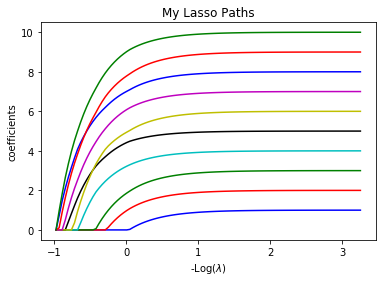

In [8]:
my_lambdas_lasso, coefs_lasso = my_lasso_path(X, y, eps, my_lambdas) # much slower than scikit-learn Cython version


# Display results
plt.figure(1)
colors = cycle(['b', 'r', 'g', 'c', 'k', 'y','m'])
neg_log_lambdas_lasso = -np.log10(my_lambdas)
for coef_l, c in zip(coefs_lasso, colors):
    l1 = plt.plot(neg_log_lambdas_lasso, coef_l, c=c)

plt.xlabel('-Log($\lambda$)')
plt.ylabel('coefficients')
plt.title('My Lasso Paths')
plt.axis('tight')

# LASSO by Proximal Gradient Descent

## Proximal Gradient Descent Framework

1. randomly set $\beta^{(0)}$ for iteration 0
2. For $k$th iteration:\
   ----Compute gradient $\nabla f(\beta^{(k-1)})$\
   ----Set $z = \beta^{(k-1)} - \frac{1}{L} \nabla f(\beta^{(k-1)})$\
   ----Update $\beta^{(k)} = \text{sgn}(z)\cdot \text{max}[|z|-\frac{\lambda}{L}, \; 0]$\
   ----Check convergence: if yes, end algorithm; else continue update\
   Endfor
   

Here $f(\beta) = \frac{1}{2N}(Y-X\beta)^T (Y-X\beta)$, and $\nabla f(\beta) = -\frac{1}{N}X^T(Y-X\beta)$,
where the size of $X$, $Y$, $\beta$ is $N\times p$, $N\times 1$, $p\times 1$, which means $N$ samples and $p$ features. Parameter $L \ge 1$ can be chosen, and $\frac{1}{L}$ can be considered as step size.

## Proximal Gradient Descent Details

Consider optimization problem:
$$\text{min}_x {f(x) + \lambda \cdot g(x)},$$
where $x\in \mathbb{R}^{p\times 1}$, $f(x) \in \mathbb{R}$. And $f(x)$ is differentiable convex function, and $g(x)$ is convex but may not differentiable.

For $f(x)$, according to Lipschitz continuity, for $\forall x, y$, there always exists a constant $L$ s.t. 
$$|f'(y) - f'(x)| \le L|y-x|.$$
Then this problem can be solved using __Proximal Gradient Descent__.

Denote $x^{(k)}$ as the $k$th updated result for $x$, then for $x\to x^{(k)}$, the proximation of $f(x)$ can be a function of $x$ and $x^{(k)}$:
\begin{align}
\hat{f}(x,x^{(k)}) 
&= f(x^{(k)}) + \nabla f^T(x^{(k)}) (x-x^{(k)}) + \frac{L}{2} \left\lVert x - x^{(k)} \right\rVert^2 \\
&= \frac{L}{2}[x - (x^{(k)} - \frac{1}{L} \nabla f(x^{(k)}))]^2 + \text{CONST} 
\end{align}
where $\text{CONST}$ is not related with $x$, so can be ignored.

The original solution for $x$ at iteration $k+1$ is
$$x^{(k+1)} = \text{argmin}_x\{ f(x) + \lambda \cdot g(x)\},$$
In proximal gradient method, we use below instead:
\begin{align}
x^{(k+1)} 
&= \text{argmin}_x\{ \hat{f}(x,x^{(k)}) +\lambda \cdot g(x) \} \\
&= \text{argmin}_x\{ \frac{L}{2}[x - (x^{(k)} - \frac{1}{L} \nabla f(x^{(k)}))]^2 + \text{CONST} +\lambda \cdot g(x) \}.
\end{align}


Given $g(x) = \left\lVert x \right\rVert_1$, and let $z = x^{(k)} - \frac{1}{L} \nabla f(x_k)$, we have
$$x^{(k+1)} = \text{argmin}_x\{ \frac{L}{2} \left\lVert x - z \right\rVert^2 + \lambda \left\lVert x \right\rVert_1 \} \label{opt_prox}.$$

To solve Eq.(\ref{opt_prox}), let $F(x) = \frac{L}{2} \sum_{j=1}^p(x_j - z_j)^2 + \lambda\sum_{j=1}^p|x_j|$. For $j$th element in $x$, it's easy to know that the optimal $x^*_j$ satisfies 
$$\frac{\partial F(x)}{\partial x_j} = L(x_j - z_j) + \lambda \cdot \text{sgn}(x_j)=0,$$
and we can get
$$z_j = x_j + \frac{\lambda}{L} \text{sgn}(x_j)$$.

The goal is to express $x^*_j$ as a function of $z_j$.This can be done by swapping the $x$-$z$ axes of the plot of $\;\;z_j = x_j + \frac{\lambda}{L} \text{sgn}(x_j)$ :
<div>
<img src="./softthreshold.jpg" width="80%"/>
</div>

Then $x_j$ can be expressed as 
\begin{align}
x_j
&= \text{sgn}(z_j)(|z_j| - \frac{\lambda}{L})_+ \\
&= \text{sgn}(z_j) \cdot \text{max}\{|z_j| - \frac{\lambda}{L},\; 0\} 
\end{align}

## Simplified Code

The code is Python version of proximal gradient descent from [Stanford MATLAB LASSO demo](https://web.stanford.edu/~boyd/papers/prox_algs/lasso.html).

In the original code, to make sure the differentiable part of objective function $f(\beta) = \frac{1}{2N} \left\lVert Y - X\beta \right\rVert^2$ will decrease after each time weight update, there is a check to see whether the first-order approximation of $f(\beta)$ is smaller than the value from previous $\beta$:
$$\text{Check whether } \frac{1}{2N} \left\lVert Y - X\beta^{(k)} \right\rVert^2 \le \frac{1}{2N} \left\lVert Y - X\beta^{(k-1)} \right\rVert^2 + \nabla f^T(\beta^{(k-1)}) (\beta^{(k)} - \beta^{(k-1)}) + \frac{L}{2} \left\lVert \beta^{(k)} - \beta^{(k-1)} \right\rVert^2$$

In [21]:
def f(X, y, w):
    n_samples, _ = X.shape
    tmp = y - np.dot(X,w)
    return 2*np.dot(tmp, tmp) / n_samples

def objective(X,y,w,lmbd):
    n_samples, _ = X.shape
    tmp = y - np.dot(X,w)
    obj_v = 2 * np.dot(tmp,tmp) / n_samples + lmbd * np.sum(np.abs(w))
    return obj_v
    

def LASSO_proximal_gradient(X, y, lmbd, L=1, max_iter=1000, tol=1e-4):
    beta = 0.5 # used to update L for finding proper step size
    n_samples, n_features = X.shape
    w = np.empty(n_features, dtype=float)
    w_prev = np.empty(n_features, dtype=float) # store the old weights
    xty_N = np.dot(X.T, y) / n_samples
    xtx_N = np.dot(X.T, X) / n_samples
    prox_thres = lmbd / L
    h_prox_optval = np.empty(max_iter, dtype=float)
    for k in range(max_iter):
        while True:
            grad_w = np.dot(xtx_N, w)- xty_N
            z = w - grad_w/L
            w_tmp = np.sign(z) * np.maximum(np.abs(z)-prox_thres, 0)
            w_diff = w_tmp - w
            if f(X, y, w_tmp) <= f(X, y, w) + np.dot(grad_w, w_diff) + L/2 * np.sum(w_diff**2):
                break
            L = L / beta
        w_prev = copy(w)
        w = copy(w_tmp)
        
        h_prox_optval[k] = objective(X,y,w,lmbd)
        if k > 0 and abs(h_prox_optval[k] - h_prox_optval[k-1]) < tol:
            break
    return w, h_prox_optval[:k]

def pgd_lasso_path(X, y, lmbds):
    n_samples, n_features = X.shape
    pgd_coefs = np.empty((n_features, len(lmbds)), dtype=float)
    for i, lmbd in enumerate(lmbds):
        w, _ = LASSO_proximal_gradient(X, y, lmbd)
        pgd_coefs[:,i] = w
    return lmbds, pgd_coefs

(-1.184363644720181,
 3.4596699798578108,
 -0.4999721963967405,
 10.49941612433155)

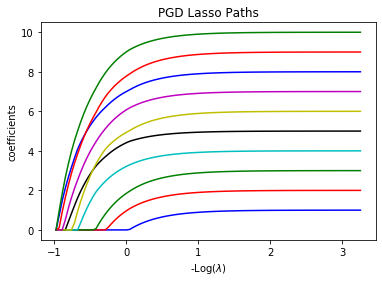

In [29]:
lmbds, pgd_coefs = pgd_lasso_path(X, y, my_lambdas)
# Display results
plt.figure(1)
colors = cycle(['b', 'r', 'g', 'c', 'k', 'y','m'])
neg_log_lambdas_lasso = -np.log10(my_lambdas)
for coef_l, c in zip(coefs_lasso, colors):
    l1 = plt.plot(neg_log_lambdas_lasso, coef_l, c=c)

plt.xlabel('-Log($\lambda$)')
plt.ylabel('coefficients')
plt.title('PGD Lasso Paths')
plt.axis('tight')

# LASSO by Accelerated Gradient Descent

# LASSO by ADMM

# Speed Comparison

In [33]:
print("Coordinate descent method from scikit-learn:")
%timeit lambdas_lasso, coefs_lasso, _ = lasso_path(X, y, eps, fit_intercept=False)

Coordinate descent method from scikit-learn:
4.88 ms ± 97 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
print("Coordinate descent method:")
%timeit my_lambdas_lasso, coefs_lasso = my_lasso_path(X, y, eps, my_lambdas) # much slower than scikit-learn Cython version

Coordinate descent method:
6.57 s ± 208 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
print("PGD method:")
%timeit lmbds, pgd_coefs = pgd_lasso_path(X, y, my_lambdas)

PGD method:
778 ms ± 21.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
